## Suggested Solver

**Note: This is only a suggested way of solving the problem. This solution is in no way complete and needs significant improvements, something we hope the competition participants will be able to do.**

**Step 1.** First convert all features into categorical features - this makes modeling easier. To do this, in this worksheet we assign a numeric value to every string. For example ```country_group': {'australia': 0,
  'bangladesh': 1,
  'sri lanka': 2,
  'new zealand': 3,
  'south africa': 4,
  'middle east': 5,
  'india': 6,
  'west indies': 7,
  'pakistan': 8,
  'north america': 9,
  'zimbabwe': 10,
  'uk': 11,
  'europe': 12,
  'east asia': 13}```
  
  Note: This is not the ideal or recommended way to do it. [Read here why and other suggestions](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

**Step 2.** Create new, more predictive features which may indicate state of the game

**Step 3.** Train a model which uses the given features to predict the probability if a given ball is a wicket. Train a few models to check which one is the best.

**Step 4.** Iteriate over the probability threshold to determine the predicted class? In this problem, given that wicket labels are around 5% of the total dataset, if you use the standard threshold of p=0.5 then, almost every model will have the predicted class "not out" for every ball. And while you will see a high accuracy (~95-96%), your model is not actually predictive.
Ideally, find the right threshold for different formats as well given wicket rates are hugely variant by format and match situation. 

Below is a simple implementation of this model. Suggested improvements could be:
1. Better conversion of non numerical features, eg: use one hot encoding
2. Create better features
3. Use a better training mechanism to predict Y (or more feature engineering before predictions)
4. Use a better method to determine threshold
5. Train separate models for batsmen and bowlers instead of one generic mmodel


In [105]:
import pandas as pd
import numpy as np
import os.path
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

In [106]:
#### LOAD THE HELPER FUNCTIONS BELOW####
#### IMPORTANT: DONOT change these functions or your final submission will not evaluate correctly###

## This downloads your datafile, Do not change this function
def downloadFile(downloadUrl, dataSetId, instrumentId):
      fileName = '%s.csv' % (instrumentId)
      url = downloadUrl + dataSetId + '/' + fileName

      response = urlopen(url)
      status = response.getcode()
      if status == 200:
          print('Downloading the dataset %s' % (fileName))
          with open(fileName, 'w') as f:
              f.write(response.read().decode('utf8'))
          return True
      else:
          logError('File not found. Please ensure you are working with correct data set Id')
          return False


#### Loading the data

In [107]:
cachedFolderName='historicalData/'
dataSetId='p1'
instrumentIds=['trainingData']
downloadUrl = 'https://qq11-data.s3.amazonaws.com/'
targetVariable = 'Out'
timeKey = 'date'
startDateStr='2010/01/01'
endDateStr='2015/12/31'
if not os.path.isfile('%s.csv' % (instrumentIds[0])):
    downloadFile(downloadUrl, dataSetId, instrumentIds[0])
df = pd.read_csv('%s.csv' % (instrumentIds[0]), index_col=0)

#### Simple data exploration

In [108]:
## Data description
print(df.shape)
print(df.columns)
print(df.dtypes)


(874860, 31)
Index(['batsman_hand', 'batsman_name', 'batsman_number', 'batting_team_name',
       'bowler_hand', 'bowler_name', 'bowler_style', 'bowling_team_name',
       'country_group', 'cumulative_balls_bowled', 'cumulative_balls_faced',
       'cumulative_balls_faced_nf', 'date', 'innings', 'innings_ball_number',
       'innings_over', 'innings_runs_before_ball', 'innings_wickets',
       'match_format', 'match_id', 'match_quality', 'over_ball', 'pplay_group',
       'required_run_rate', 'target', 'toss_choice', 'toss_winner',
       'venue_name', 'chasing', 'PreviousBallOut', 'Out'],
      dtype='object')
batsman_hand                  object
batsman_name                  object
batsman_number                 int64
batting_team_name             object
bowler_hand                   object
bowler_name                   object
bowler_style                  object
bowling_team_name             object
country_group                 object
cumulative_balls_bowled        int64
cumulative_

In [109]:
data = df.copy()

In [110]:
batsmen = data['batsman_name'].unique()
bowler = data['bowler_name'].unique()
batting_team = data['batting_team_name'].unique()
bowler_style = data['bowler_style'].unique()
bowling_team = data['bowling_team_name'].unique()
country = data['country_group'].unique() 
mformat = data['match_format'].unique()
pplay = data['pplay_group'].unique()
venue = data['venue_name'].unique()
# wicket = data['wicket_type'].unique()

In [111]:
print(batsmen)


['Phil Jaques' 'David Warner' 'Usman Khawaja' ... 'Suboth Bhati'
 'Navdeep Saini' 'Sam Heazlett']


In [112]:
data['date'] = pd.to_datetime(data['date'])

### Step 1 convert to categorical variables

In [113]:
## listing non numerical variabels
listf = []
for c in data.columns:
    if data[c].dtype==object:
        print(c, data[c].dtype)
        listf.append(c)

batsman_hand object
batsman_name object
batting_team_name object
bowler_hand object
bowler_name object
bowler_style object
bowling_team_name object
country_group object
pplay_group object
toss_choice object
toss_winner object
venue_name object


In [114]:
from sklearn import preprocessing

feature_dict ={}
for feature in data.columns:
    if data[feature].dtype==object:  
        le = preprocessing.LabelEncoder()
        fs = data[feature].unique()
        f_dict = {}
        le.fit(fs)
        data[feature] = le.transform(data[feature])
        feature_dict[feature] = le

#### Remove any NaNs and separate the target variable

In [115]:
data[data.isnull().any(axis=1)]
data = data.dropna()
del data['date']

In [116]:
# pd.get_dummies(s1)
y = data['Out']
del data['Out']

### Step 2: Add new features

In [128]:
### an interesting feature might be number of runs scored in last 6 balls 
### and number of wickets in last 6 balls to see if there is pressure on the team

data['run_last_6_balls'] = data['innings_runs_before_ball'].rolling(6).sum()
data['run_last_12_balls'] = data['innings_runs_before_ball'].rolling(12).sum()
data['wkt_last_6_balls'] = data['PreviousBallOut'].rolling(6).sum()
data['wkt_last_12_balls'] = data['PreviousBallOut'].rolling(12).sum()

### remeber to set these as 0 start of the game
data['run_last_6_balls'][data['innings_ball_number']<6] = 0
data['run_last_12_balls'][data['innings_ball_number']<12] = data['run_last_6_balls']
data['wkt_last_6_balls'][data['innings_ball_number']<6] = 0
data['wkt_last_12_balls'][data['innings_ball_number']<12] = data['wkt_last_6_balls']
data.fillna(0, inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


### Step 3: Create train-test split and train a few models

In [122]:
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state = 10) 

In [123]:
 # training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 10).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

# accuracy on X_test 
accuracy = dtree_model.score(X_test, y_test) 
print(accuracy)

lg = log_loss(y_test, dtree_predictions)
print(lg)

# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions)
cm

0.9605841366614541
1.3613759395480012


array([[194109,     63],
       [  7902,      2]])

In [125]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
# from sklearn.neighbors import RadiusNeighborsClassifier
# neigh = RadiusNeighborsClassifier(radius=1.0).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors = 10, weights='distance').fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
# accuracy = neigh.score(X_test, y_test) 
print(accuracy)
  
lg = log_loss(y_test, knn_predictions)
print(lg)

# creating a confusion matrix 

cm = confusion_matrix(y_test, knn_predictions)
# neigh_predictions = neigh.predict(X_test)  
# cm = confusion_matrix(y_test, neigh_predictions)
cm

0.9548090817316257
1.5608441137008708


array([[192885,   1287],
       [  7845,     59]])

In [126]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy)

lg = log_loss(y_test, gnb_predictions)
print(lg)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 
cm

0.9592628516003879
1.4070126721589276


array([[193815,    357],
       [  7875,     29]])

In [127]:
# training a Random Forest classifier 
from sklearn.ensemble import RandomForestClassifier
rforest_model = RandomForestClassifier(n_estimators=300, max_depth=8,random_state=0).fit(X_train, y_train) 
rforest_predictions = rforest_model.predict(X_test) 

# accuracy on X_test 
accuracy = rforest_model.score(X_test, y_test) 
print(accuracy)

lg = log_loss(y_test, rforest_predictions)
print(lg)

# creating a confusion matrix 
cm = confusion_matrix(y_test, rforest_predictions)
cm

0.9608860032858925
1.3509495864198335


array([[194172,      0],
       [  7904,      0]])

### Step 4: Identify probability threshold

As you can see, most classifiers predict with most balls as 0 (not out), because that is the most frequent class. Hence, we cannot directly compare these models. We can try to play with the probability threshold and see if we can then get a better sense of which is a good model.

In [131]:
evaluate_clf = dtree_model

In [132]:
for i in range(len(X_test.columns)):
    print(X_test.columns[i], evaluate_clf.feature_importances_[i])

batsman_hand 0.003080632383627136
batsman_name 0.049104760558625046
batsman_number 0.01938912554322939
batting_team_name 0.01795717024401828
bowler_hand 0.0
bowler_name 0.05783127051066477
bowler_style 0.0
bowling_team_name 0.02592892897110298
country_group 0.01822338945549373
cumulative_balls_bowled 0.07323932425709308
cumulative_balls_faced 0.056261583744685484
cumulative_balls_faced_nf 0.08185039597161349
innings 0.0
innings_ball_number 0.07824201296464009
innings_over 0.005391106671347488
innings_runs_before_ball 0.0490265023674257
innings_wickets 0.00823902641262121
match_format 0.010012055246788191
match_id 0.07463327281878118
match_quality 0.003055208194679058
over_ball 0.024572417371092774
pplay_group 0.0018615886612028247
required_run_rate 0.059068009541891814
target 0.025053712471807862
toss_choice 0.00682067493829611
toss_winner 0.016011637131646946
venue_name 0.050458164415389216
chasing 0.0
PreviousBallOut 0.007894120483044536
run_last_6_balls 0.05455112455043882
run_last_

In [133]:
z = evaluate_clf.predict_proba(X_test)
for i in range(len(y_test)):
    if y_test.iloc[i]>0:
        print(y_test.iloc[i])
        print(z[i])

1.0
[0.95446021 0.04553979]
1.0
[0.95376374 0.04623626]
1.0
[0.94986383 0.05013617]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.94986383 0.05013617]
1.0
[0.96436871 0.03563129]
1.0
[0.95904652 0.04095348]
1.0
[0.95446021 0.04553979]
1.0
[0.9567713 0.0432287]
1.0
[0.96749254 0.03250746]
1.0
[0.96338418 0.03661582]
1.0
[0.95904652 0.04095348]
1.0
[0.94391534 0.05608466]
1.0
[0.96211397 0.03788603]
1.0
[0.96749254 0.03250746]
1.0
[0.93894542 0.06105458]
1.0
[0.9953271 0.0046729]
1.0
[0.96749254 0.03250746]
1.0
[0.96322933 0.03677067]
1.0
[0.96021392 0.03978608]
1.0
[0.95904652 0.04095348]
1.0
[0.95904652 0.04095348]
1.0
[0.96338418 0.03661582]
1.0
[0.96066863 0.03933137]
1.0
[0.95904652 0.04095348]
1.0
[0.96436871 0.03563129]
1.0
[0.96021392 0.03978608]
1.0
[0.93894542 0.06105458]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03788603]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.94986383 0.05013617]
1.0
[0.96749254 0.032507

1.0
[0.95446021 0.04553979]
1.0
[0.96322933 0.03677067]
1.0
[0.96211397 0.03788603]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.97164179 0.02835821]
1.0
[0.96211397 0.03788603]
1.0
[0.95842688 0.04157312]
1.0
[0.95376374 0.04623626]
1.0
[0.96489618 0.03510382]
1.0
[0.94775984 0.05224016]
1.0
[0.95446021 0.04553979]
1.0
[0.96211397 0.03788603]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96582269 0.03417731]
1.0
[0.95446021 0.04553979]
1.0
[0.95376374 0.04623626]
1.0
[0.97164179 0.02835821]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.95842688 0.04157312]
1.0
[0.95904652 0.04095348]
1.0
[0.97482014 0.02517986]
1.0
[0.9567713 0.0432287]
1.0
[0.95446021 0.04553979]
1.0
[0.9787234 0.0212766]
1.0
[0.96021392 0.03978608]
1.0
[0.96436871 0.03563129]
1.0
[0.96749254 0.03250746]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.94775984 0.052240

[0.96338418 0.03661582]
1.0
[0.95842688 0.04157312]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.95942245 0.04057755]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.95376374 0.04623626]
1.0
[0.95376374 0.04623626]
1.0
[0.96021392 0.03978608]
1.0
[0.96477414 0.03522586]
1.0
[0.9122807 0.0877193]
1.0
[0.96338418 0.03661582]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.94986383 0.05013617]
1.0
[0.96489618 0.03510382]
1.0
[0.96021392 0.03978608]
1.0
[0.97384361 0.02615639]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.96436871 0.03563129]
1.0
[0.95904652 0.04095348]
1.0
[0.94986383 0.05013617]
1.0
[0.95842688 0.04157312]
1.0
[0.95376374 0.04623626]
1.0
[0.96322933 0.03677067]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.95077484 0.04922516

1.0
[0.97384361 0.02615639]
1.0
[0.95904652 0.04095348]
1.0
[0.97971602 0.02028398]
1.0
[0.97844496 0.02155504]
1.0
[0.96021392 0.03978608]
1.0
[0.89153439 0.10846561]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.97243993 0.02756007]
1.0
[0.99423631 0.00576369]
1.0
[0.96485623 0.03514377]
1.0
[0.95446021 0.04553979]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03788603]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.97482014 0.02517986]
1.0
[0.95839906 0.04160094]
1.0
[0.96211397 0.03788603]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.97706422 0.02293578]
1.0
[0.94986383 0.05013617]
1.0
[0.96749254 0.03250746]
1.0
[0.95839906 0.04160094]
1.0
[0.96582269 0.03417731]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.95446021 0.04553979]
1.0
[0.88721805 0.11278195]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03

1.0
[0.96211397 0.03788603]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.97311475 0.02688525]
1.0
[0.93103448 0.06896552]
1.0
[0.97971602 0.02028398]
1.0
[0.96338418 0.03661582]
1.0
[0.96338418 0.03661582]
1.0
[0.93617021 0.06382979]
1.0
[0.96582269 0.03417731]
1.0
[0.95839906 0.04160094]
1.0
[0.95904652 0.04095348]
1.0
[0.95446021 0.04553979]
1.0
[0.96338418 0.03661582]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.95446021 0.04553979]
1.0
[0.96066863 0.03933137]
1.0
[0.95904652 0.04095348]
1.0
[0.95422808 0.04577192]
1.0
[0.96211397 0.03788603]
1.0
[0.95842688 0.04157312]
1.0
[0.97243993 0.02756007]
1.0
[0.96021392 0.03978608]
1.0
[0.94986383 0.05013617]
1.0
[0.94986383 0.05013617]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.94901961 0.05098039]
1.0
[0.96021392 0.03978608]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.9567713 0.0432287]
1.0
[0.93617021 0.06382979]
1.0
[0.94901961 0.05098039]
1.0
[0.95942245 0.0405

1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.9567713 0.0432287]
1.0
[0.9530262 0.0469738]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03788603]
1.0
[0.96338418 0.03661582]
1.0
[0.96021392 0.03978608]
1.0
[0.96021392 0.03978608]
1.0
[0.95904652 0.04095348]
1.0
[0.96098875 0.03901125]
1.0
[0.96021392 0.03978608]
1.0
[0.96021392 0.03978608]
1.0
[0.96322933 0.03677067]
1.0
[0.96211397 0.03788603]
1.0
[0.9530262 0.0469738]
1.0
[0.95422808 0.04577192]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.96067079 0.03932921]
1.0
[0.96322933 0.03677067]
1.0
[0.96582269 0.03417731]
1.0
[0.96211397 0.03788603]
1.0
[0.95904652 0.04095348]
1.0
[0.97596154 0.02403846]
1.0
[0.97458704 0.02541296]
1.0
[0.96067079 0.03932921]
1.0
[0.95904652 0.04095348]
1.0
[0.96338418 0.03661582]
1.0
[0.96338418 0.03661582]
1.0
[0.95757576 0.04242424]
1.0
[0.95904652 0.04095348]
1.0
[0.95839906 0.04160094

[0.95842688 0.04157312]
1.0
[0.97482014 0.02517986]
1.0
[0.95842688 0.04157312]
1.0
[0.96749254 0.03250746]
1.0
[0.95842688 0.04157312]
1.0
[0.95446021 0.04553979]
1.0
[0.95446021 0.04553979]
1.0
[0.96211397 0.03788603]
1.0
[0.93514461 0.06485539]
1.0
[0.97482014 0.02517986]
1.0
[0.96749254 0.03250746]
1.0
[0.94986383 0.05013617]
1.0
[0.96021392 0.03978608]
1.0
[0.98351823 0.01648177]
1.0
[0.94986383 0.05013617]
1.0
[0.95446021 0.04553979]
1.0
[0.97311475 0.02688525]
1.0
[0.95904652 0.04095348]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.97311475 0.02688525]
1.0
[0.96021392 0.03978608]
1.0
[0.95376374 0.04623626]
1.0
[0.96021392 0.03978608]
1.0
[0.96021392 0.03978608]
1.0
[0.94252874 0.05747126]
1.0
[0.96582269 0.03417731]
1.0
[0.95839906 0.04160094]
1.0
[0.95904652 0.04095348]
1.0
[0.95904652 0.04095348]
1.0
[0.97384361 0.02615639]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.96338418 0.03661582]
1.0
[0.95376374 0.046236

1.0
[0.96211397 0.03788603]
1.0
[0.95842688 0.04157312]
1.0
[0.97596154 0.02403846]
1.0
[0.96338418 0.03661582]
1.0
[0.97004019 0.02995981]
1.0
[0.96338418 0.03661582]
1.0
[0.96582269 0.03417731]
1.0
[0.9122807 0.0877193]
1.0
[0. 1.]
1.0
[0.96021392 0.03978608]
1.0
[0.96338418 0.03661582]
1.0
[0.92585366 0.07414634]
1.0
[0.95839906 0.04160094]
1.0
[0.97004019 0.02995981]
1.0
[0.97243993 0.02756007]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03788603]
1.0
[0.95904652 0.04095348]
1.0
[0.96338418 0.03661582]
1.0
[0.95842688 0.04157312]
1.0
[0.97243993 0.02756007]
1.0
[0.95904652 0.04095348]
1.0
[0.94775984 0.05224016]
1.0
[0.96749254 0.03250746]
1.0
[0.95446021 0.04553979]
1.0
[0.94391534 0.05608466]
1.0
[0.96066863 0.03933137]
1.0
[0.96749254 0.03250746]
1.0
[0.96098875 0.03901125]
1.0
[0.9567713 0.0432287]
1.0
[0.95904652 0.04095348]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.94986383 0.05013617]
1.0
[0.96749254 0.03250746]
1.0
[0.96749

[0.96749254 0.03250746]
1.0
[0.97243993 0.02756007]
1.0
[0.96749254 0.03250746]
1.0
[0.95446021 0.04553979]
1.0
[0.95446021 0.04553979]
1.0
[0.96338418 0.03661582]
1.0
[0.99542683 0.00457317]
1.0
[0.96066863 0.03933137]
1.0
[0.95842688 0.04157312]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.95446021 0.04553979]
1.0
[0.98351823 0.01648177]
1.0
[0.95462046 0.04537954]
1.0
[0.95446021 0.04553979]
1.0
[0.96338418 0.03661582]
1.0
[0.95942245 0.04057755]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.94986383 0.05013617]
1.0
[0.95904652 0.04095348]
1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.96098875 0.03901125]
1.0
[0.96338418 0.03661582]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96338418 0.03661582]
1.0
[0.96749254 0.03250746]
1.0
[0.96679988 0.03320012]
1.0
[0.96749254 0.03250746]
1.0
[0.95842688 0.04157312]
1.0
[0.95942245 0.040577

1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.96098875 0.03901125]
1.0
[0.96338418 0.03661582]
1.0
[0.96338418 0.03661582]
1.0
[0.94775984 0.05224016]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.96582269 0.03417731]
1.0
[0.96322933 0.03677067]
1.0
[0.97596154 0.02403846]
1.0
[0.96849174 0.03150826]
1.0
[0.95839906 0.04160094]
1.0
[0.96322933 0.03677067]
1.0
[0.94986383 0.05013617]
1.0
[0.97311475 0.02688525]
1.0
[0.95904652 0.04095348]
1.0
[0.93768546 0.06231454]
1.0
[0.95904652 0.04095348]
1.0
[0.97243993 0.02756007]
1.0
[0.97164179 0.02835821]
1.0
[0.95839906 0.04160094]
1.0
[0.96338418 0.03661582]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.96338418 0.03661582]
1.0
[0.97164179 0.02835821]
1.0
[0.96489618 0.03510382]
1.0
[0.95376374 0.04623626]
1.0
[0.95400788 0.04599212]
1.0
[0.96067079 0.03932921]
1.0
[0.97354497 0.02

1.0
[0.95462046 0.04537954]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.93723849 0.06276151]
1.0
[0.95376374 0.04623626]
1.0
[0.95446021 0.04553979]
1.0
[0.95839906 0.04160094]
1.0
[0.96322933 0.03677067]
1.0
[0.96211397 0.03788603]
1.0
[0.97384361 0.02615639]
1.0
[0.97311475 0.02688525]
1.0
[0.94986383 0.05013617]
1.0
[0.96338418 0.03661582]
1.0
[0.96211397 0.03788603]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.97004019 0.02995981]
1.0
[0.95839906 0.04160094]
1.0
[0.9567713 0.0432287]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.89153439 0.10846561]
1.0
[0.9567713 0.0432287]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.95842688 0.04157312]
1.0
[0.96436871 0.03563129]
1.0
[0.94457547 0.05542453]
1.0
[0.97004019 0.02995981]
1.0
[0.94986383 0.05013617]
1.0
[0.96582269 0.03417731]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.96582269 0.034177

[0.96749254 0.03250746]
1.0
[0.95075758 0.04924242]
1.0
[0.96749254 0.03250746]
1.0
[0.96338418 0.03661582]
1.0
[0.96338418 0.03661582]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.95446021 0.04553979]
1.0
[0.95446021 0.04553979]
1.0
[0.95942245 0.04057755]
1.0
[0.88721805 0.11278195]
1.0
[0.96021392 0.03978608]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.97971602 0.02028398]
1.0
[0.96021392 0.03978608]
1.0
[0.94391534 0.05608466]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.97243993 0.02756007]
1.0
[0.96749254 0.03250746]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.96021392 0.03978608]
1.0
[0.96338418 0.03661582]
1.0
[0.96021392 0.03978608]
1.0
[0.96066863 0.03933137]
1.0
[0.93514461 0.06485539]
1.0
[0.95446021 0.04553979]
1.0
[0.96211397 0.03788603]
1.0
[0.96489618 0.03510382]
1.0
[0.97243993 0.027560

1.0
[0.92525773 0.07474227]
1.0
[0.96322933 0.03677067]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.95842688 0.04157312]
1.0
[0.96211397 0.03788603]
1.0
[0.95839906 0.04160094]
1.0
[0.96338418 0.03661582]
1.0
[0.96021392 0.03978608]
1.0
[0.95904652 0.04095348]
1.0
[0.95842688 0.04157312]
1.0
[0.96749254 0.03250746]
1.0
[0.99423631 0.00576369]
1.0
[0.96021392 0.03978608]
1.0
[0.96338418 0.03661582]
1.0
[0.95839906 0.04160094]
1.0
[0.97596154 0.02403846]
1.0
[0.92243767 0.07756233]
1.0
[0.96211397 0.03788603]
1.0
[0.96211397 0.03788603]
1.0
[0.94775984 0.05224016]
1.0
[0.96582269 0.03417731]
1.0
[0.96322933 0.03677067]
1.0
[0.96322933 0.03677067]
1.0
[0.94986383 0.05013617]
1.0
[0.95462046 0.04537954]
1.0
[0.95446021 0.04553979]
1.0
[0.96679988 0.03320012]
1.0
[0.97004019 0.02995981]
1.0
[0.95904652 0.04095348]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.94986383 0.05013617]
1.0
[0.95904652 0.04095348]
1.0
[0.96436871 0.03

1.0
[0.95446021 0.04553979]
1.0
[0.96021392 0.03978608]
1.0
[0.9953271 0.0046729]
1.0
[0.96338418 0.03661582]
1.0
[0.96749254 0.03250746]
1.0
[0.96436871 0.03563129]
1.0
[1. 0.]
1.0
[0.96021392 0.03978608]
1.0
[0.94326241 0.05673759]
1.0
[0.96211397 0.03788603]
1.0
[0.96211397 0.03788603]
1.0
[0.97243993 0.02756007]
1.0
[0.96211397 0.03788603]
1.0
[0.94775984 0.05224016]
1.0
[0.96021392 0.03978608]
1.0
[0.95446021 0.04553979]
1.0
[0.96211397 0.03788603]
1.0
[0.95842688 0.04157312]
1.0
[0.96749254 0.03250746]
1.0
[0.96582269 0.03417731]
1.0
[0.95842688 0.04157312]
1.0
[0.97164179 0.02835821]
1.0
[0.96477414 0.03522586]
1.0
[0.96338418 0.03661582]
1.0
[0.95077484 0.04922516]
1.0
[0.94391534 0.05608466]
1.0
[0.95904652 0.04095348]
1.0
[0.9567713 0.0432287]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.95842688 0.04157312]
1.0
[0.96489618 0.03510382]
1.0
[0.96021392 0.03978608]
1.0
[0.98351

1.0
[0.96021392 0.03978608]
1.0
[0.95842688 0.04157312]
1.0
[0.9567713 0.0432287]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.9567713 0.0432287]
1.0
[0.95842688 0.04157312]
1.0
[0.95376374 0.04623626]
1.0
[0.89208633 0.10791367]
1.0
[0.9530262 0.0469738]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03788603]
1.0
[0.96338418 0.03661582]
1.0
[0.94775984 0.05224016]
1.0
[0.96021392 0.03978608]
1.0
[0.96066863 0.03933137]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96211397 0.03788603]
1.0
[0.96021392 0.03978608]
1.0
[0.94986383 0.05013617]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.97384361 0.02615639]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.96021392 0.03978608]
1.0
[0.95904652 0.04095348]
1.0
[0.9567713 0.0432287]
1.0
[0.97243993 0.02756007]
1.0
[0.95446021 0.04553979]
1.0
[0.98351823 0.01648177]
1.0
[0.94117647 0.05882353]


[0.97243993 0.02756007]
1.0
[0.95842688 0.04157312]
1.0
[0.94775984 0.05224016]
1.0
[0.96749254 0.03250746]
1.0
[0.96485623 0.03514377]
1.0
[0.94986383 0.05013617]
1.0
[0.96021392 0.03978608]
1.0
[0.96021392 0.03978608]
1.0
[0.96338418 0.03661582]
1.0
[0.95842688 0.04157312]
1.0
[0.95839906 0.04160094]
1.0
[0.93472091 0.06527909]
1.0
[0.96749254 0.03250746]
1.0
[0.96338418 0.03661582]
1.0
[0.96338418 0.03661582]
1.0
[0.94986383 0.05013617]
1.0
[0.96749254 0.03250746]
1.0
[0.96597353 0.03402647]
1.0
[0.95446021 0.04553979]
1.0
[0.95400788 0.04599212]
1.0
[0.96021392 0.03978608]
1.0
[0.96211397 0.03788603]
1.0
[0.96338418 0.03661582]
1.0
[0.95904652 0.04095348]
1.0
[0.97164179 0.02835821]
1.0
[0.96749254 0.03250746]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96021392 0.03978608]
1.0
[0.95904652 0.04095348]
1.0
[0.96021392 0.03978608]
1.0
[0.97164179 0.02835821]
1.0
[0.96338418 0.03661582]
1.0
[0.96098875 0.03901125]
1.0
[0.9567713 0.0432287]
1.0
[0.96749254 0.03250746

[0.96211397 0.03788603]
1.0
[0.93472091 0.06527909]
1.0
[0.96582269 0.03417731]
1.0
[0.96098875 0.03901125]
1.0
[0.96066863 0.03933137]
1.0
[0.96021392 0.03978608]
1.0
[0.9567713 0.0432287]
1.0
[0.875 0.125]
1.0
[0.95422808 0.04577192]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.96322933 0.03677067]
1.0
[0.96338418 0.03661582]
1.0
[0.92574257 0.07425743]
1.0
[0.95904652 0.04095348]
1.0
[0.95842688 0.04157312]
1.0
[0.96021392 0.03978608]
1.0
[0.96749254 0.03250746]
1.0
[0.96489618 0.03510382]
1.0
[0.94775984 0.05224016]
1.0
[0.96338418 0.03661582]
1.0
[0.96373057 0.03626943]
1.0
[0.95842688 0.04157312]
1.0
[0.95446021 0.04553979]
1.0
[0.95842688 0.04157312]
1.0
[0.95904652 0.04095348]
1.0
[0.95446021 0.04553979]
1.0
[0.95904652 0.04095348]
1.0
[0.96749254 0.03250746]
1.0
[0.96749254 0.03250746]
1.0
[0.97164179 0.02835821]
1.0
[0.95842688 0.04157312]
1.0
[0.96749254 0.03250746]
1.0
[0.95876289 0.04123711]
1.0
[0.96749254 0.03250746]
1.0
[0.95422808 0.04577192]
1.0
[0.9

[0.96749254 0.03250746]
1.0
[0.94986383 0.05013617]
1.0
[0.94986383 0.05013617]
1.0
[0.96021392 0.03978608]
1.0
[0.96477414 0.03522586]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.95376374 0.04623626]
1.0
[0.96489618 0.03510382]
1.0
[0.95376374 0.04623626]
1.0
[0.95446021 0.04553979]
1.0
[0.94986383 0.05013617]
1.0
[0.96021392 0.03978608]
1.0
[0.95376374 0.04623626]
1.0
[0.93055556 0.06944444]
1.0
[0.97311828 0.02688172]
1.0
[0.95446021 0.04553979]
1.0
[0.97243993 0.02756007]
1.0
[0.95446021 0.04553979]
1.0
[0.96749254 0.03250746]
1.0
[0.96098875 0.03901125]
1.0
[0.94986383 0.05013617]
1.0
[0.97311475 0.02688525]
1.0
[0.96021392 0.03978608]
1.0
[0.95839906 0.04160094]
1.0
[0.97384361 0.02615639]
1.0
[0.96211397 0.03788603]
1.0
[0.96211397 0.03788603]
1.0
[0.97844496 0.02155504]
1.0
[0.96211397 0.03788603]
1.0
[0.9530262 0.0469738]
1.0
[0.96211397 0.03788603]
1.0
[0.96211397 0.03788603]
1.0
[0.96021392 0.03978608]
1.0
[0.97243993 0.02756007]
1.0
[0.98431373 0.01568627

Now we compute precision-recall pairs for different probability thresholds

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [144]:
y_scores = evaluate_clf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [148]:
import matplotlib.pyplot as plt
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p)#, color='b', alpha=0.2,
#              where='post')
    plt.fill_between(r, p)#, step='post', alpha=0.2,
#                      color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    return y_pred_adj

     pred_neg  pred_pos
neg    178240     15932
pos      7116       788


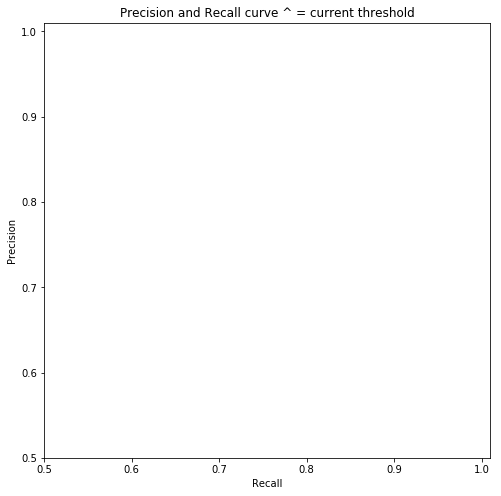

In [149]:
y_new = precision_recall_threshold(p, r, thresholds, t=0.05)

In [137]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.5317089341326289


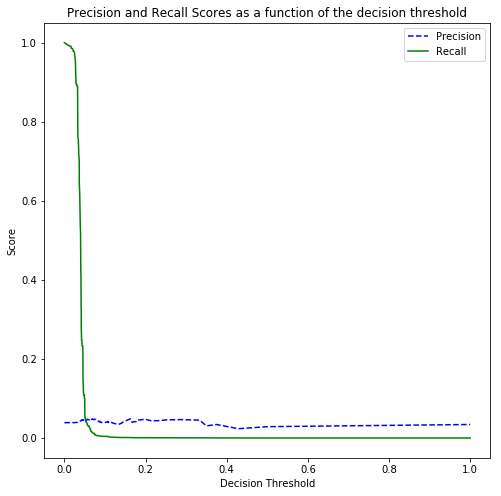

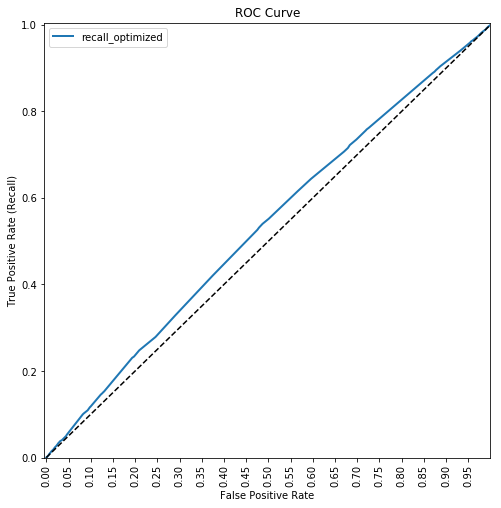

In [138]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [139]:
accuracy_score(y_test, y_new)

0.617084661216572